# Example

In [3]:
import pandas as pd

data = pd.read_csv("../kaggle/titanic_data/train.csv")

# select subset of predictors
cols_to_use = ["PassengerId","Pclass","Age","SibSp","Parch","Fare"]
X = data[cols_to_use]

# select target
y = data.Survived

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [5]:
my_pipeline = Pipeline(steps=[("preprocessor", SimpleImputer()),
                            ("model", RandomForestRegressor(n_estimators=100))
                             ])

In [6]:
from sklearn.model_selection import cross_val_score

scores = -1 * cross_val_score(my_pipeline, X, y,
                             cv=5,
                             scoring="neg_mean_absolute_error")

print("MAE scores:\n", scores)

MAE scores:
 [0.4626257  0.40955056 0.37123596 0.32393258 0.3994382 ]


In [7]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
0.39335660033896175


# Preprocessing

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("../kaggle/titanic_data/train.csv")
test_data = pd.read_csv("../kaggle/titanic_data/test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# separate target from predictors
y = train_data.Survived
X = train_data.drop(["Survived"], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.8, test_size=0.2)


In [10]:
categorical_cols = []
for col in X_train_full.columns:
    if X_train_full[col].nunique() < 10 and X_train_full[col].dtype == "object":
        categorical_cols.append(col)
print(categorical_cols)

['Sex', 'Embarked']


In [11]:
numerical_cols = []
for col in X_train_full.columns:
    if X_train_full[col].dtype in ["int64", "float64"]:
        numerical_cols.append(col)
print(numerical_cols)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [12]:
my_cols = categorical_cols + numerical_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [13]:
X_train.head()

,Sex,Embarked,PassengerId,Pclass,Age,SibSp,Parch,Fare
570,male,S,571,2,62.0,0,0,10.500
126,male,Q,127,3,NaN,0,0,7.750
276,female,S,277,3,45.0,0,0,7.750
58,female,S,59,2,5.0,1,2,27.750
400,male,S,401,3,39.0,0,0,7.925


## 1. Define Preprocessing Steps

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# preprocessing numerical data
numerical_transformer = SimpleImputer(strategy="mean")

# preprocessing categorical data
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


## 2. Define the Model

In [62]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=400, max_depth=5)

## 3. Create and Evaluate the Pipeline

In [79]:
from sklearn.metrics import mean_absolute_error

# bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_valid)

score = mean_absolute_error(y_valid, preds)
print("MAE:", score)

MAE: 0.16759776536312848


In [64]:
test_preds = my_pipeline.predict(test_data[my_cols])


In [65]:
output = pd.DataFrame({"PassengerId":test_data.PassengerId,
                     "Survived":test_preds})

output.to_csv("submission.csv", index=False)

## 4. Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score

scores = -1 * cross_val_score(my_pipeline, X, y,
                             cv=5,
                             scoring="neg_mean_absolute_error")
print("MAE scores:\n", scores)

MAE scores:
 [0.17877095 0.17977528 0.17977528 0.20786517 0.15730337]


In [20]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
0.18069801016885317


## 5. Write a useful function

In [80]:
def get_score(n_estimators):
    valid_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        #("xgb_model", XGBClassifier(n_estimators=n_estimators, max_depth=5, n_jobs=8))
        ("model", RandomForestClassifier(n_estimators=n_estimators, max_depth=5, random_state=1))
    ])
    
    scores = -1 * cross_val_score(valid_pipeline, X, y,
                                 cv=5,
                                 scoring="neg_mean_absolute_error")
    
    return scores.mean()

## 6. Test different parameter values

In [81]:
results = {}
for i in range(1,13):
     results[i*50] = get_score(i*50)
print(results)

{50: 0.19748917205448496, 100: 0.18516728391186993, 150: 0.18404996547611574, 200: 0.18516100684200615, 250: 0.1851735609817337, 300: 0.18293264704036155, 350: 0.18181532860460736, 400: 0.18070428723871695, 450: 0.17958069173309898, 500: 0.18070428723871695, 550: 0.18069801016885317, 600: 0.18293264704036155}


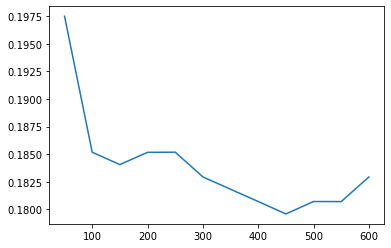

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()